# RFM Modeling with K-Means

Data source: [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx).

RFM Modeling:
- Recency, frequency, monetary value (RFM) is a marketing analysis tool used to identify a company's or an organization's best customers by measuring and analyzing spending habits.
- RFM analysis helps firms reasonably predict which customers are likely to purchase their products again, how much revenue comes from new (versus repeat) clients, and how to turn occasional buyers into habitual ones. ["investopedia"](https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp)

#### Project description:
Segment customers using different RFM modeling techniques. This will enable us to create relevant and personalized marketing and sales strategies for each segment.

#### Content
1. Importing required libraries
2. Loading the data
3. RFM Modeling
    1. Recency
    2. Frequency
    3. Monetary Value
    4. Exploring RFM distribution
4. RFM Modeling with quartile binning
	1. Building quartile based RFM generator function
	2. Exploring the quartile based RFM model
5. RFM Modeling with K-Means
	1. Log transformation of the data
	2. Scaling the data
	3. Transformed data visualization
	4. Calculating optimal number of clusters
	5. Buliding K-Means based RFM generator function
	6. Using the functions
	7. Labeling clusters

### 1. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify  # to generate treemap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import gc # to garbage collect
import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('ggplot')
sns.set(style='white')

### 2. Loading the data

NOTE: We use the data we cleaned in Cohort_Analysis_mini_project.ipynb in this project.<br/>
For more details refer to Cohort_Analysis_mini_project.ipynb cleaning section.

In [3]:
# loading transactional data
df = pd.read_csv('.\df_orders.csv', usecols=['customer_id', 'invoice_date', 'invoice_id', 'order_value'], parse_dates=['invoice_date'])

df.head()

,customer_id,invoice_date,invoice_id,order_value
0,12346.0,2009-12-14 08:34:00,491725,45.0
1,12346.0,2009-12-14 11:00:00,491742,22.5
2,12346.0,2009-12-14 11:02:00,491744,22.5
3,12346.0,2009-12-18 10:47:00,492718,22.5
4,12346.0,2009-12-18 10:55:00,492722,1.0


### 3. RFM Modeling
RFM modeling is a customer centric approach. IOur aim is to find an RFM score for each customer to be used in segmentation. <br/>
To avoid missing valueable information, we calculate RFM for the whole dataset and not for a specific time period (e.g. yearly)

#### Recency

For recency, we simply find the date of the last purchase and the difference with the present time for each customer.
This means that RFM is a dynamic method and needs to be performed periodically.

NOTE: We assume present time for our dataset to be the day after the last date in the dataset

In [4]:
# calculating the present date and normalizing for midnight
present_date = df.invoice_date.dt.normalize().max() + pd.Timedelta(days=1)
present_date

Timestamp('2011-12-10 00:00:00')

In [5]:
# grouping by customer and finding the lastest order date
df_rfm = df.groupby('customer_id')[['invoice_date']].max().rename(columns={'invoice_date': 'latest_invoice_date'})
df_rfm['present_day'] = present_date

# finding the difference between present day and the normalized lastest order date per customer
df_rfm['recency'] = (df_rfm['present_day'] - df_rfm['latest_invoice_date'].dt.normalize()).dt.days

df_rfm.head()

,latest_invoice_date,present_day,recency
customer_id,,,
12346.0,2011-01-18 10:01:00,2011-12-10,326
12347.0,2011-12-07 15:52:00,2011-12-10,3
12348.0,2011-09-25 13:13:00,2011-12-10,76
12349.0,2011-11-21 09:51:00,2011-12-10,19
12350.0,2011-02-02 16:01:00,2011-12-10,311


In [6]:
# dropping 'latest_invoice_date', 'present_date' columns since we don't need them anymore
df_rfm.drop(columns=['latest_invoice_date', 'present_day'], inplace=True)

#### Frequency
For purchase frequency, we count the number of orders for each customer.

In [7]:
df_rfm['frequency'] = df.groupby('customer_id')[['invoice_id']].count()
df_rfm.head()

,recency,frequency
customer_id,,
12346.0,326,12
12347.0,3,8
12348.0,76,5
12349.0,19,4
12350.0,311,1


#### Monetary Value
For monetary value, we add up all the orders value for each customer in the timeframe of the dataset.

In [8]:
df_rfm['monetary_value'] = df.groupby('customer_id')[['order_value']].sum().round(2)
df_rfm.head()

,recency,frequency,monetary_value
customer_id,,,
12346.0,326,12,77556.46
12347.0,3,8,4921.53
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


#### Exploring RFM distribution
Looking at the distributions, we can see the data is skewed to the right which is common in ecommerce. However, this may cause problem with equal binning in RFM scoring which we will explore more when we perform quartile binning later on.

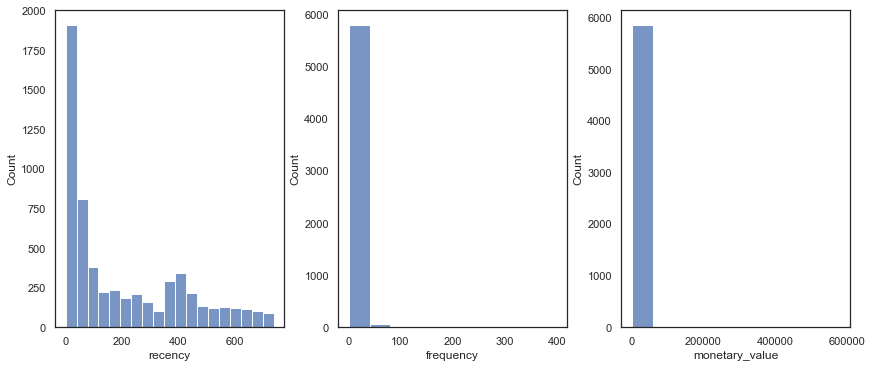

In [9]:
# plotting distribution of recency, frequency and monetary_value columns
fig, ax = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True, sharey=False)

sns.histplot(df_rfm.recency, label='recency', ax=ax[0])
sns.histplot(df_rfm.frequency, bins=10, label='frequency', ax=ax[1])
sns.histplot(df_rfm.monetary_value.round(), bins=10, label='monetary value', ax=ax[2])

plt.show()

### 4. RFM Modeling with quartile binning

One way to assign an RFM score to each customer is to use quartil binning. <br/>

NOTE: when using pd.qcut, pandas buckets the data based on their rank with 'average' method which means the same values in the data will get the same rank and if they fall on the bin edge, then we will have an overlap, meaning some of the same values will be in one bucket and the rest in the next bucket. This will cause a problem with labeling the buckets. To avoid that, we can explicitly rank the data before bucketing using the 'first' method which gives a unique rank value to each data point.

In [10]:
# scoring 'recency', 'frequency' and 'monetary_value' columns based on 5 equal quartiles
df_rfm['r_score'] = pd.qcut(df_rfm['recency'].rank(method='first'), q=5, labels=[5, 4, 3, 2, 1])
df_rfm['f_score'] = pd.qcut(df_rfm['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
df_rfm['m_score'] = pd.qcut(df_rfm['monetary_value'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

df_rfm.head()

,recency,frequency,monetary_value,r_score,f_score,m_score
customer_id,,,,,,
12346.0,326,12,77556.46,2,5,5
12347.0,3,8,4921.53,5,4,5
12348.0,76,5,2019.40,3,4,4
12349.0,19,4,4428.69,5,3,5
12350.0,311,1,334.40,2,1,2


In [11]:
# calculating rfm_score along with rfm_segment which is a label made from 'recency', 'frequency' and 'monetary_value' scores
df_rfm['rfm_segment'] = df_rfm.r_score.astype('str') + df_rfm.f_score.astype('str') + df_rfm.m_score.astype('str')
df_rfm['rfm_score'] = df_rfm.r_score.astype('int') + df_rfm.f_score.astype('int') + df_rfm.m_score.astype('int')
df_rfm.head()

,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_segment,rfm_score
customer_id,,,,,,,,
12346.0,326,12,77556.46,2,5,5,255,12
12347.0,3,8,4921.53,5,4,5,545,14
12348.0,76,5,2019.40,3,4,4,344,11
12349.0,19,4,4428.69,5,3,5,535,13
12350.0,311,1,334.40,2,1,2,212,5


In [12]:
del df_rfm
gc.collect()

123

#### Building quartile based RFM generator function
Now that we know how RFM is calculated, we can create a function to calculate it for any transactional df in one step.<br/>
In this function, we also label the segments using equal quartiles. However, the labeling is a process which depends on the business and needs more investigation.

In [13]:
# create the rfm df
def get_rfm(df, present_date, q=5):

    # creating 'recency', 'frequency' and 'monetary_value' columns
    rfm = df.groupby('customer_id').agg({
        'invoice_date': lambda x: (present_date - x.max()).days,
        'invoice_id': 'count',
        'order_value': 'sum'
    })

    rfm.columns = ['recency', 'frequency', 'monetary_value']

    # descending list for recency labels to give higher label to lower recency 
    r_labels = np.arange(q, 0, -1)
    
    # ascending list for frequency and monetary_value labels
    fm_labels = np.arange(1, q+1, 1)

    # creating score columns for 'recency', 'frequency' and 'monetary_value' columns
    rfm['r_score'] = pd.qcut(rfm['recency'].rank(method='first'), q=5, labels=r_labels).astype('int')
    rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), q=5, labels=fm_labels).astype('int')
    rfm['m_score'] = pd.qcut(rfm['monetary_value'].rank(method='first'), q=5, labels=fm_labels).astype('int')

    # creating rfm segment for quick evaluation of customer rfm status
    rfm ['rfm_label'] = rfm.r_score.astype('str') + rfm.f_score.astype('str') + rfm.m_score.astype('str')

    # creating rfm score
    rfm['rfm_score'] = rfm.r_score + rfm.f_score + rfm.m_score

    # Assigning labels based on rfm score quartiles
    rfm_segments = ['very low', 'low', 'middle', 'high', 'very high']
    rfm['rfm_segment'] = pd.qcut(rfm['rfm_score'].rank(method='first'), q=5, labels=rfm_segments)
    
    rfm.reset_index(inplace=True)

    return rfm

In [14]:
df_rfm = get_rfm(df, present_date)
df_rfm.head()

,customer_id,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_label,rfm_score,rfm_segment
0,12346.0,325,12,77556.46,2,5,5,255,12,high
1,12347.0,2,8,4921.53,5,4,5,545,14,very high
2,12348.0,75,5,2019.40,3,4,4,344,11,high
3,12349.0,18,4,4428.69,5,3,5,535,13,high
4,12350.0,310,1,334.40,2,1,2,212,5,very low


#### Exploring the quartile based RFM model

As we can see in below charts, due to the skewed nature of the dataset, the quartile based model has a hard time seperating rfm columns scores properly.

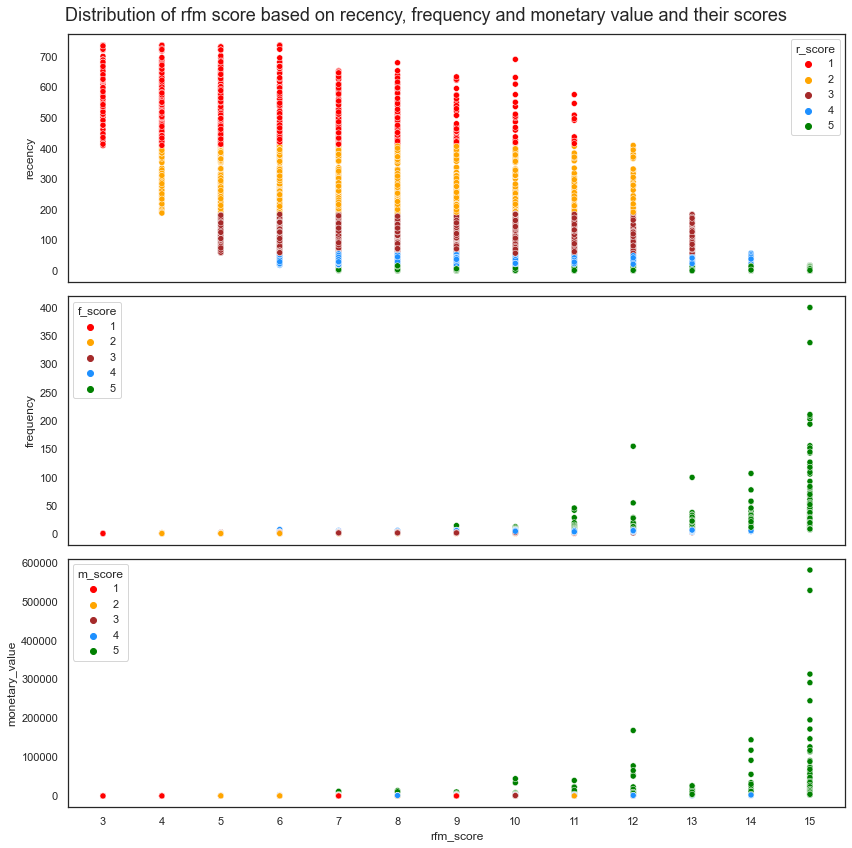

In [15]:
# plotting the distribution of rfm scores based on recency, frequency and monetary value and their scores
palette=['red','orange','brown','dodgerblue','green']

fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
sns.scatterplot(x=df_rfm.rfm_score, y=df_rfm.recency, hue=df_rfm.r_score, ax=ax[0], palette=palette)
sns.scatterplot(x=df_rfm.rfm_score, y=df_rfm.frequency, hue=df_rfm.f_score, ax=ax[1], palette=palette)
sns.scatterplot(x=df_rfm.rfm_score, y=df_rfm.monetary_value, hue=df_rfm.m_score, ax=ax[2], palette=palette)

ax[2].set_xticks(df_rfm.rfm_score.unique())
plt.suptitle('Distribution of rfm score based on recency, frequency and monetary value and their scores', fontsize=18)
plt.tight_layout()
plt.show()

As the previous and below graphs show, the model particualrly has a hard time to correctly incorporate recency in the final rfm score.

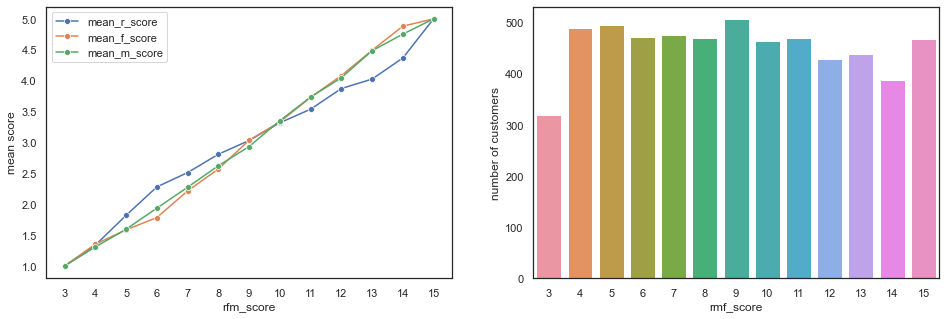

In [16]:
# calculating mean scores for each rfm_score
rfm_q_stats = df_rfm.groupby('rfm_score').agg(
    customers = ('customer_id', 'count'),
    mean_r_score = ('r_score','mean'), 
    mean_f_score = ('f_score', 'mean'), 
    mean_m_score = ('m_score', 'mean'),
    )

# plotting scores
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
 
sns.lineplot(data=rfm_q_stats, x='rfm_score', y='mean_r_score', marker='o', label='mean_r_score', ax=ax[0])
sns.lineplot(data=rfm_q_stats, x='rfm_score', y='mean_f_score', marker='o', label='mean_f_score', ax=ax[0])
sns.lineplot(data=rfm_q_stats, x='rfm_score', y='mean_m_score', marker='o', label='mean_m_score', ax=ax[0])

sns.barplot(x=rfm_q_stats.index, y=rfm_q_stats.customers, label='mean_m_score', ax=ax[1])

ax[0].set_xticks(df_rfm.rfm_score.unique())
ax[0].set(ylabel='mean score')
ax[1].set(xlabel='rmf_score', ylabel='number of customers')
plt.show()

In [17]:
# calculating segment average value
rfm_q_segments = df_rfm.groupby('rfm_segment')[['customer_id', 'monetary_value', 'rfm_score']].agg(
    customers= ('customer_id','count'),
    mean_rfm_score = ('rfm_score', 'mean'),
    segment_value= ('monetary_value', 'sum'),
)

rfm_q_segments['segment_avg_value'] = rfm_q_segments.segment_value.div(rfm_q_segments.customers).round()

rfm_q_segments

,customers,mean_rfm_score,segment_value,segment_avg_value
rfm_segment,,,,
very low,1177,4.040782,286634.99,244.0
low,1176,6.466837,650116.68,553.0
middle,1176,8.943878,1329091.13,1130.0
high,1176,11.426871,3153919.83,2682.0
very high,1176,14.124150,11954489.76,10165.0


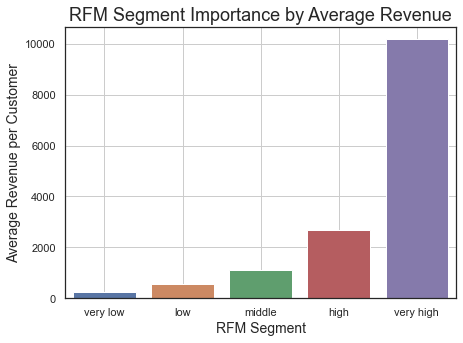

In [18]:
plt.figure(figsize=(7, 5))
sns.barplot(x=rfm_q_segments.index, y=rfm_q_segments.segment_avg_value, label='segment_avg_value')
plt.xlabel('RFM Segment', fontsize=14)
plt.ylabel('Average Revenue per Customer', fontsize=14)
plt.title('RFM Segment Importance by Average Revenue', fontsize=18)
plt.grid(True)
plt.show()

### 5. RFM Modeling with K-Means

As shown earlier, due to the skweness of RFM components, equal binning doesn't properly segment the customers. <br/>
One solution to overcome the skewness is to utilize log transformation of the data and let K-means clustring find the segments for us which we will explore more in the following section.

#### Log transformation of the data
Befor applying any log transformation, we need to make sure we don't have any negative or zero values in our RFM components. That's because log is not defined for that domain of x. <br/>
NOTE: negative values can happen in recency column if the present day is before the date we are calculating the recency for, and monetary value can be negative if for example we have returns in our dataset.

In [19]:
# Initiating the new df for kmeans segmentation
df_rfm_kmeans = df_rfm.loc[:, ['customer_id', 'recency', 'frequency', 'monetary_value']]

# converting zeros and negatives to 1 which will be equal to 0 when log transformed
df_rfm_kmeans['recency'] = df_rfm.recency.apply(lambda x: 1 if x<=0 else x)
df_rfm_kmeans['frequency'] = df_rfm.frequency.apply(lambda x: 1 if x<=0 else x)
df_rfm_kmeans['monetary_value'] = df_rfm.monetary_value.apply(lambda x: 1 if x<=0 else x)

# log transformation of RFM components 
df_rfm_kmeans[['recency_log', 'frequency_log', 'monetary_value_log']] = df_rfm_kmeans[['recency', 'frequency', 'monetary_value']].apply(np.log, axis=1)

df_rfm_kmeans.head()

,customer_id,recency,frequency,monetary_value,recency_log,frequency_log,monetary_value_log
0,12346.0,325,12,77556.46,5.783825,2.484907,11.258761
1,12347.0,2,8,4921.53,0.693147,2.079442,8.501375
2,12348.0,75,5,2019.40,4.317488,1.609438,7.610556
3,12349.0,18,4,4428.69,2.890372,1.386294,8.395859
4,12350.0,310,1,334.40,5.736572,0.000000,5.812338


#### Scaling the data

We will scale our data before applying K-means since K-means is a distance based algorithm and scaling will optimze the cost function convergence.

In [20]:
# Instantiating the scaler
scaler = StandardScaler()

# fitting the log transformed data
scaled_data = scaler.fit_transform(df_rfm_kmeans[['recency_log', 'frequency_log', 'monetary_value_log']])
rfm_scaled = pd.DataFrame(scaled_data, index=df_rfm_kmeans.index, columns=['recency_log_scaled', 'frequency_log_scaled', 'monetary_value_log_scaled'])

df_rfm_kmeans[['recency_log_scaled', 'frequency_log_scaled', 'monetary_value_log_scaled']] = rfm_scaled
df_rfm_kmeans.head()

,customer_id,recency,frequency,monetary_value,recency_log,frequency_log,monetary_value_log,recency_log_scaled,frequency_log_scaled,monetary_value_log_scaled
0,12346.0,325,12,77556.46,5.783825,2.484907,11.258761,0.836726,1.245565,3.183409
1,12347.0,2,8,4921.53,0.693147,2.079442,8.501375,-2.207694,0.851536,1.209967
2,12348.0,75,5,2019.40,4.317488,1.609438,7.610556,-0.040200,0.394789,0.572414
3,12349.0,18,4,4428.69,2.890372,1.386294,8.395859,-0.893670,0.177939,1.134450
4,12350.0,310,1,334.40,5.736572,0.000000,5.812338,0.808467,-1.169254,-0.714558


#### Transformed data visualization

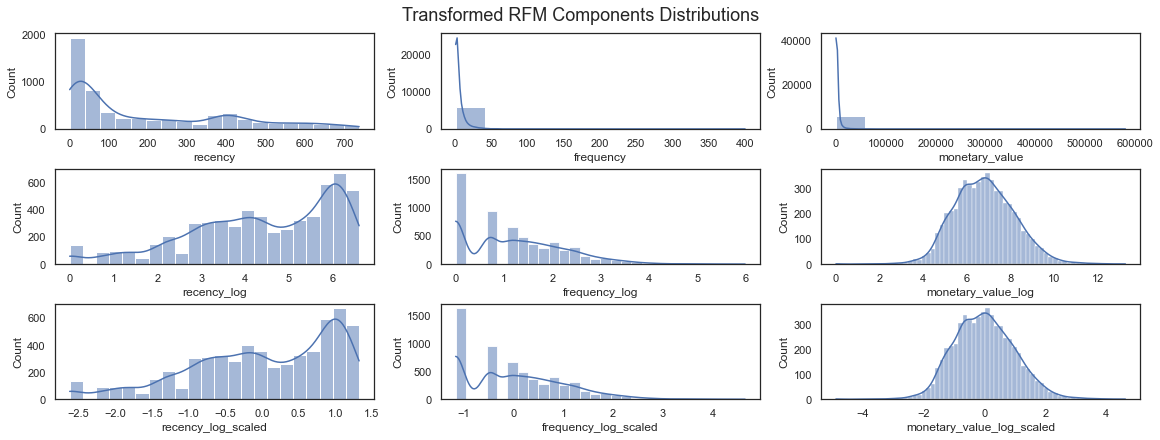

In [21]:
# plotting distribution of recency, frequency and monetary_value columns as they are transformed
fig, axs = plt.subplots(3, 3, figsize=(16, 6), constrained_layout=True, sharey=False)

for col, ax in zip(df_rfm_kmeans.columns[1:], axs.ravel()):
    if col in ['frequency', 'monetary_value']:
        sns.histplot(df_rfm_kmeans[col], bins=10, label=col, ax=ax, kde=True)
    else:
        sns.histplot(df_rfm_kmeans[col], label=col, ax=ax, kde=True)

plt.suptitle('Transformed RFM Components Distributions', fontsize=18)
plt.show()

#### Calculating optimal number of clusters

To find the best number of clusters for our segmentation, we use the elbow method as below:

In [22]:
# Finding the optimal k

# sum of squared distances within cluster points
ssd = {}

for k in range(1, 10):
    model = KMeans(n_clusters=k, n_init=100)
    model.fit(rfm_scaled)
    ssd[k] = model.inertia_

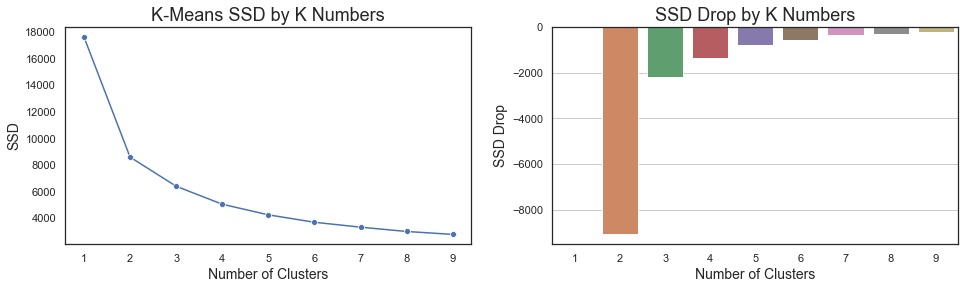

In [23]:
# plotting ssd and sdd drop per cluster size

fig, axs = plt.subplots(1, 2, figsize=(16, 4))

sns.lineplot(x=ssd.keys(), y=ssd.values(), marker='o', ax=axs[0])
axs[0].set_title('K-Means SSD by K Numbers', fontsize=18)
axs[0].set_xlabel('Number of Clusters', fontsize=14)
axs[0].set_ylabel('SSD', fontsize=14)

ssd_drop = pd.Series(ssd).diff()
sns.barplot(x=ssd_drop.index, y=ssd_drop.values, ax=axs[1])
axs[1].set_title('SSD Drop by K Numbers', fontsize=18)
axs[1].set_xlabel('Number of Clusters', fontsize=14)
axs[1].set_ylabel('SSD Drop', fontsize=14)
plt.grid(axis='y')

plt.show()

K=3 seems like a good candidate with the highest SDD drop, however, we would like to segment our customers to more than 3 so we choose 4 for this project.

#### Buliding K-Means based RFM generator function
Now that we know how RFM for K-Means is calculated, we can create 2 functions to transform data and return an elbow graph for us to choose the best cluster number.

In [24]:
# log transform and scale
def transform_data(rfm):

    # columns fron rfm df we need to transform
    cols = ['recency', 'frequency', 'monetary_value']

    # log transforming and scaling columns
    for col in cols:
        rfm[col] = np.log(rfm[col].apply(lambda x: 1 if x<=0 else x))
    
    rfm_scaled = StandardScaler().fit_transform(rfm[cols])
    
    # naming transformed columns
    col_names = ['recency_log_scaled', 'frequency_log_scaled', 'monetary_value_log_scaled']
    rfm_transformed = pd.DataFrame(rfm_scaled, index=rfm.index, columns=col_names)

    return rfm_transformed

In [25]:
# getting elbow method
def get_elbow_plot(rfm_transformed, k=10, n_init=100, random_state=None):

    # calculating ssd for cluter sizes
    ssd = {}
    for i in range(1, k+1):
        ssd[i] = KMeans(n_clusters=i, n_init=n_init, random_state=random_state).fit(rfm_transformed).inertia_

    # plotting elbow method
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # plotting ssd per cluster size
    sns.lineplot(x=ssd.keys(), y=ssd.values(), marker='o', ax=axs[0])
    axs[0].set_title('K-Means SSD by K Numbers', fontsize=18)
    axs[0].set_xlabel('Number of Clusters', fontsize=14)
    axs[0].set_ylabel('SSD', fontsize=14)

    # plotting ssd change per cluster size
    ssd_drop = pd.Series(ssd).diff()
    sns.barplot(x=ssd_drop.index, y=ssd_drop.values, ax=axs[1])
    axs[1].set_title('SSD Drop by K Numbers', fontsize=18)
    axs[1].set_xlabel('Number of Clusters', fontsize=14)
    axs[1].set_ylabel('SSD Drop', fontsize=14)
    plt.grid(axis='y')

    plt.show()    

In [26]:
# predicting labels
def predict_labels(rfm_transformed, k=4, n_init=100, random_state=None):
    
    model_labels = KMeans(n_clusters=k, n_init=n_init, random_state=random_state).fit_predict(rfm_transformed)
    clusters = pd.DataFrame(model_labels, index=rfm_transformed.index, columns=['cluster_number'])

    return clusters

#### Using the functions

First, we create our rfm df using get_rfm() function we created earlier.

In [27]:
# creating rfm df
rfm_df = get_rfm(df, present_date=present_date)
rfm_df.head()

,customer_id,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_label,rfm_score,rfm_segment
0,12346.0,325,12,77556.46,2,5,5,255,12,high
1,12347.0,2,8,4921.53,5,4,5,545,14,very high
2,12348.0,75,5,2019.40,3,4,4,344,11,high
3,12349.0,18,4,4428.69,5,3,5,535,13,high
4,12350.0,310,1,334.40,2,1,2,212,5,very low


Then we log transform and scale rfm components from the rfm_df using transform_data() function.

In [28]:
# transforing data
rfm_transformed = transform_data(rfm_df.copy())
rfm_transformed.head()

,recency_log_scaled,frequency_log_scaled,monetary_value_log_scaled
0,0.836726,1.245565,3.183409
1,-2.207694,0.851536,1.209967
2,-0.040200,0.394789,0.572414
3,-0.893670,0.177939,1.134450
4,0.808467,-1.169254,-0.714558


Now we can use get_elbow_plot() function to choose the best cluster size.

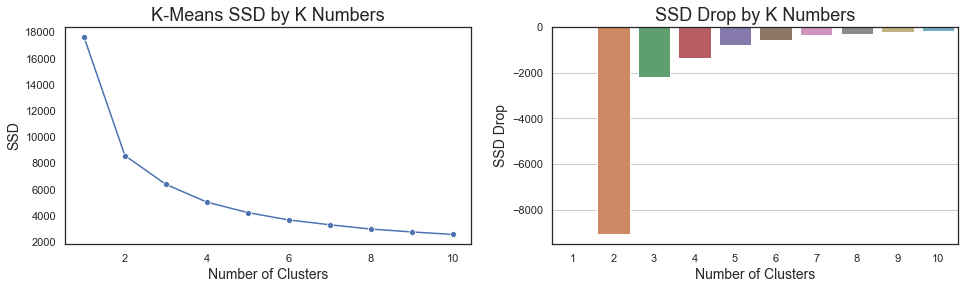

In [29]:
# plotting SSD
get_elbow_plot(rfm_transformed, k=10, n_init=100)

We choose k=4 and for the final step we use predict_labels() functions to find cluster labels and will add it to our rfm df.

In [30]:
# predicting cluster labels
clusters = predict_labels(rfm_transformed, k=4, n_init=100, random_state=42)

# adding the labels to rmf df
rfm_df['cluster_num'] = clusters
rfm_df.head()

,customer_id,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_label,rfm_score,rfm_segment,cluster_num
0,12346.0,325,12,77556.46,2,5,5,255,12,high,2
1,12347.0,2,8,4921.53,5,4,5,545,14,very high,2
2,12348.0,75,5,2019.40,3,4,4,344,11,high,1
3,12349.0,18,4,4428.69,5,3,5,535,13,high,2
4,12350.0,310,1,334.40,2,1,2,212,5,very low,3


In [31]:
rfm_df['cluster_num'].value_counts()


3    1970
1    1559
2    1216
0    1136
Name: cluster_num, dtype: int64

#### Labeling clusters
Now, we need to find the meaning of cluster numbers to label them in a meaningful way. There are several ways we can do this which we examin a few below.

One way is to compare cluster numebrs with rfm segments we have already created using a snake plot. The highest and lowest of the RFM segments indicate the high and low in the cluster numbers.

In [32]:
# adding rfm_transformed columns to rmd_df
log_scaled_columns = ['recency_log_scaled', 'frequency_log_scaled', 'monetary_value_log_scaled']
rfm_df[log_scaled_columns] = rfm_transformed

# melting columns for snake plots
df_unpivot = pd.melt(rfm_df, id_vars=['customer_id', 'cluster_num', 'rfm_segment'], value_vars=log_scaled_columns, value_name='rfm_value', var_name='rfm_metric')
df_unpivot.head()

,customer_id,cluster_num,rfm_segment,rfm_metric,rfm_value
0,12346.0,2,high,recency_log_scaled,0.836726
1,12347.0,2,very high,recency_log_scaled,-2.207694
2,12348.0,1,high,recency_log_scaled,-0.040200
3,12349.0,2,high,recency_log_scaled,-0.893670
4,12350.0,3,very low,recency_log_scaled,0.808467


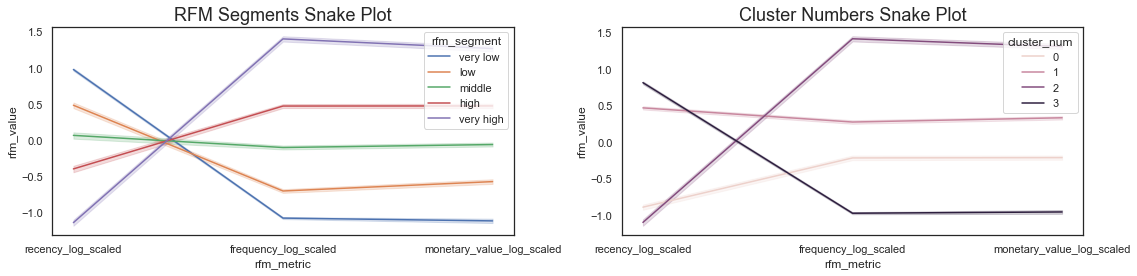

In [33]:
# Plotting snake plots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
sns.lineplot(x=df_unpivot['rfm_metric'], y=df_unpivot['rfm_value'], hue=df_unpivot['rfm_segment'], ax=axs[0])
sns.lineplot(x=df_unpivot['rfm_metric'], y=df_unpivot['rfm_value'], hue=df_unpivot['cluster_num'], ax=axs[1])
axs[0].set_title('RFM Segments Snake Plot', fontsize=18)
axs[1].set_title('Cluster Numbers Snake Plot', fontsize=18)
plt.tight_layout()
plt.show()

Based on above charts, cluster number 2 has the highest value, cluster 3 has the lowest value.<br/>
So the descending order for cluster labels would be 2, 1, 0, 3 

In [34]:
rfm_df.head()

,customer_id,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_label,rfm_score,rfm_segment,cluster_num,recency_log_scaled,frequency_log_scaled,monetary_value_log_scaled
0,12346.0,325,12,77556.46,2,5,5,255,12,high,2,0.836726,1.245565,3.183409
1,12347.0,2,8,4921.53,5,4,5,545,14,very high,2,-2.207694,0.851536,1.209967
2,12348.0,75,5,2019.40,3,4,4,344,11,high,1,-0.040200,0.394789,0.572414
3,12349.0,18,4,4428.69,5,3,5,535,13,high,2,-0.893670,0.177939,1.134450
4,12350.0,310,1,334.40,2,1,2,212,5,very low,3,0.808467,-1.169254,-0.714558


Another way is to group RFM metrics by rfm_segment and cluster_num seperately and then divide each by ungrouped RFM metrics average to find the deviation from ungrouped RFM metrics mean. Then we can utilize a heatmap to find corresponding labels.

In [35]:
# rfm metrics mean
rfm_mean = rfm_df.loc[:, ['recency', 'frequency', 'monetary_value']].mean()
rfm_mean

recency            200.992858
frequency            6.298079
monetary_value    2954.302396
dtype: float64

In [36]:
# rfm metrics mean grouped by rfm_segment
rfm_segment_mean = rfm_df.groupby('rfm_segment')[['recency', 'frequency', 'monetary_value']].mean()

# rfm_segment_mean deviation from rfm_mean
rfm_segment_mean_deviation = rfm_segment_mean.div(rfm_mean).sub(1)
rfm_segment_mean_deviation

,recency,frequency,monetary_value
rfm_segment,,,
very low,1.286555,-0.819233,-0.917568
low,0.361934,-0.712146,-0.812876
middle,-0.171295,-0.465877,-0.617446
high,-0.593460,0.004653,-0.092204
very high,-0.884828,1.993300,2.440874


In [37]:
# rfm metrics mean grouped by cluster_num
cluster_num_mean = rfm_df.groupby('cluster_num')[['recency', 'frequency', 'monetary_value']].mean()

# cluster_num mean deviation from rfm_mean
cluster_num_mean_deviation = cluster_num_mean.div(rfm_mean).sub(1)
cluster_num_mean_deviation

,recency,frequency,monetary_value
cluster_num,,,
0,-0.868553,-0.510246,-0.716318
1,0.146384,-0.203561,-0.366318
2,-0.869423,2.020710,2.586875
3,0.921666,-0.791976,-0.893813


Based on below graphs, we can conclude again that the cluster numbers in ascending order are 2, 1, 0, 3

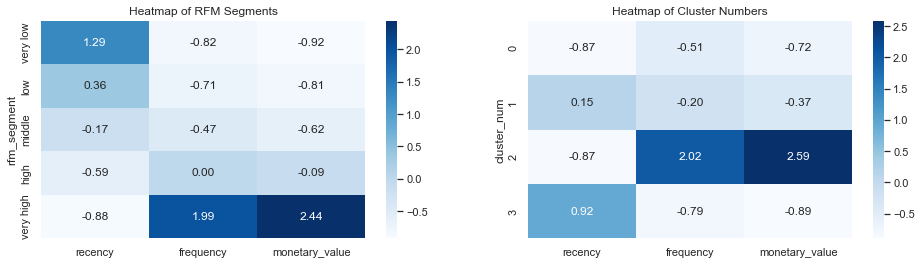

In [38]:
# Plotting snake plots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

sns.heatmap(rfm_segment_mean_deviation, fmt= '.2f', annot = True, cmap= 'Blues', ax=axs[0])
sns.heatmap(cluster_num_mean_deviation, fmt= '.2f', annot = True, cmap= 'Blues', ax=axs[1])

axs[0].set_title('Heatmap of RFM Segments')
axs[1].set_title('Heatmap of Cluster Numbers')

plt.show()

Now we can rename the cluster numbers as below

In [39]:
# creating cluster labels column
labels_dict = {2:'platinum', 1:'gold', 0: 'silver', 3:'bronze'}
rfm_df['cluster_label'] = rfm_df['cluster_num'].replace(labels_dict)

#### Exploring Clusters

In [40]:
rfm_df.drop(columns=['recency_log_scaled', 'frequency_log_scaled', 'monetary_value_log_scaled'], inplace=True)
rfm_df.head()

,customer_id,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_label,rfm_score,rfm_segment,cluster_num,cluster_label
0,12346.0,325,12,77556.46,2,5,5,255,12,high,2,platinum
1,12347.0,2,8,4921.53,5,4,5,545,14,very high,2,platinum
2,12348.0,75,5,2019.40,3,4,4,344,11,high,1,gold
3,12349.0,18,4,4428.69,5,3,5,535,13,high,2,platinum
4,12350.0,310,1,334.40,2,1,2,212,5,very low,3,bronze


As we can see below, K-means has been able to do a better job in classifying RFM metrics into seperate segments.

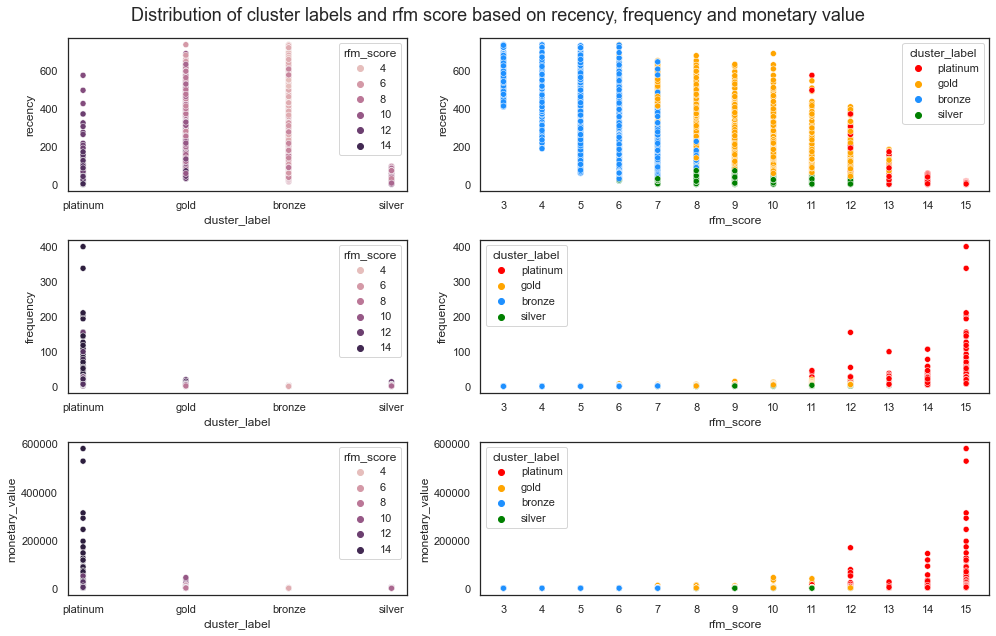

In [41]:
# plotting the distribution of cluster labels and rfm score based on recency, frequency and monetary value
palette=['red','orange','dodgerblue','green']
cols = ['recency', 'frequency', 'monetary_value']

fig, axs = plt.subplots(3, 2, figsize=(14, 9), gridspec_kw={'width_ratios': [1, 1.5]})

for col, i in zip(cols, range(3)):
    sns.scatterplot(x=rfm_df.cluster_label, y=rfm_df[col], hue=rfm_df.rfm_score, ax=axs[i, 0])
    sns.scatterplot(x=rfm_df.rfm_score, y=rfm_df[col], hue=rfm_df.cluster_label, ax=axs[i, 1], palette=palette)

    axs[i, 1].set_xticks(rfm_df.rfm_score.unique())

plt.suptitle('Distribution of cluster labels and rfm score based on recency, frequency and monetary value', fontsize=18)
plt.tight_layout()
plt.show()

In [42]:
# grouping by kmeans clusters
rfm_k_segments = rfm_df.groupby('cluster_label')[['customer_id', 'recency', 'frequency', 'monetary_value']].agg(
    customers = ('customer_id', 'count'), 
    avg_recency = ('recency', 'mean'), 
    avg_frequency = ('frequency', 'mean'), 
    segment_value = ('monetary_value', 'sum')
    )

rfm_k_segments['segment_avg_value'] = rfm_k_segments.segment_value.div(rfm_k_segments.customers).round()
rfm_k_segments = rfm_k_segments.sort_values(by='segment_avg_value')

rfm_k_segments

,customers,avg_recency,avg_frequency,segment_value,segment_avg_value
cluster_label,,,,,
bronze,1970,386.241117,1.310152,618003.67,314.0
silver,1136,26.419894,3.084507,952063.06,838.0
gold,1559,230.415010,5.016036,2918583.41,1872.0
platinum,1216,26.245066,19.024671,12885602.25,10597.0


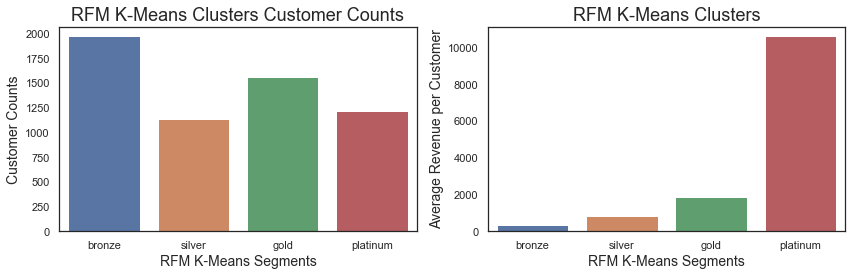

In [43]:
fig, axs = plt.subplots(1, 2, figsize = (12,4))

# plotting number of customers per segment
sns.barplot(x=rfm_k_segments.index, y=rfm_k_segments.customers, label='customers', ax=axs[0])
axs[0].set_xlabel('RFM K-Means Segments', fontsize=14)
axs[0].set_ylabel('Customer Counts', fontsize=14)
axs[0].set_title('RFM K-Means Clusters Customer Counts', fontsize=18)

# plotting average revenue per segment
sns.barplot(x=rfm_k_segments.index, y=rfm_k_segments.segment_avg_value, label='segment_avg_value', ax=axs[1])
axs[1].set_xlabel('RFM K-Means Segments', fontsize=14)
axs[1].set_ylabel('Average Revenue per Customer', fontsize=14)
axs[1].set_title('RFM K-Means Clusters', fontsize=18)

plt.tight_layout()
plt.show()

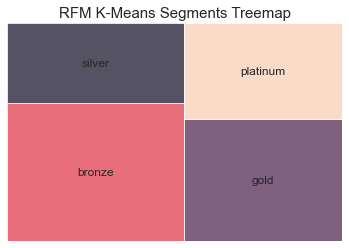

In [44]:
fig, ax = plt.subplots(figsize = (6,4))

squarify.plot(sizes=rfm_k_segments['customers'], label=rfm_k_segments.index, alpha=0.7)

plt.title('RFM K-Means Segments Treemap', fontsize=15)
plt.axis('off')
plt.show()